In [1]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#8F003C','#eb3446','Tourney','Smokum',45,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h4 class='font-effect-3d-float' style='font-family:"""+\
    font+"""; color:"""+fontcolor+"""; font-size:"""+\
    str(fontsize)+"""px;'>%s</h4>"""%string))
    
    
dhtml('🔥💥 Beginner Twitter Sentiment Analysis 🔥💥' )

**The objective of this task is to detect hate speech in tweets**. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets. Formally, given a training sample of tweets and labels, where **label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist**, the objective is to predict the labels on the test dataset.

Full tweet texts are provided with their labels for training data.
**Mentioned users' username is replaced with @user.**

The dataset is provided by **Analytics Vidhya**

**I hope you find this kernel useful and your UPVOTES would be very much appreciated**

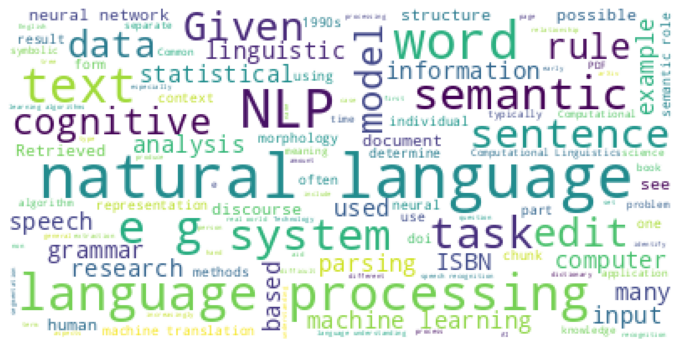

## Importing Libraries

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1,h2 {
    text-align: center;
    background-color: pink;
    padding: 20px;
    margin: 0;
    color: white;
    font-family: ariel;
    border-radius: 80px
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-family: ariel;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}
</style>
""")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer


from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

## Loading in the Data and simple preprocessing

In [4]:
df = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [5]:
# Dropping the redundant column 'id'
df = df.drop('id',axis = 'columns')

In [6]:
print(f'The shape of the data is {df.shape}')

The shape of the data is (31962, 2)


In [7]:
df = df.drop_duplicates(keep='first')

In [8]:
print(f'After checking for duplicates: The shape of the data is {df.shape}')

After checking for duplicates: The shape of the data is (29530, 2)


In [9]:
print(f'Checking for null values in data....... \n{df.isnull().any()}')

Checking for null values in data....... 
label    False
tweet    False
dtype: bool


In [10]:
pos = 100*len(df.loc[df['label']==0,'label'])/len(df['label'])
neg = 100*len(df.loc[df['label']==1,'label'])/len(df['label'])
print(f'Percentage of Negative Sentiment tweets is {pos}')
print(f'Percentage of Postitive Sentiment tweets is {neg}')
print('\nClearly, The data is heavily Imbalanced')

Percentage of Negative Sentiment tweets is 93.18320352184219
Percentage of Postitive Sentiment tweets is 6.816796478157806

Clearly, The data is heavily Imbalanced


## Basic Feature Extraction Functions

In [11]:
stop_words = stopwords.words('english')

### Hashtags Count

#### **One interesting feature which we can extract from a tweet is to calculate the number of hashtags in it. It helps in extracting extra information from our text data.**

In [12]:
def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

### Word Count

#### **Usually, negative sentiments contain a lesser amount of words than the positive ones. So, this is a feature worth trying out**

In [13]:
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

### Character Count

#### **Similar logic as above can be applied here**

In [14]:
def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x: sum(list(map(len,x.split(' ')))))

### Number Count

#### **Just like we calculated the number of words and characters, we can also calculate the number of numerics which are present in the tweets. It might be a useful feature**

In [15]:
def num_of_num(df):
    df['num_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

### Stopwords Count

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [16]:
def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

### Uppercase words

#### **Anger or rage is quite often expressed by writing in UPPERCASE words which makes this a necessary operation to identify those words.**

In [17]:
def num_of_upper(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

### Feature Extraction Function

In [18]:
def feature_extract(df):
    num_of_hash_tags(df)
    num_of_num(df)
    num_of_chars(df)
    num_of_stop_words(df)
    num_of_upper(df)

## Text Preprocessing

In [19]:
# Lemmatization
Word = WordNetLemmatizer()

###  Removing hyperlinks and markup

In [20]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
#     result = re.sub('&quot;', '"', result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result

### Removing Emojis

In [21]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### Removing Punctuation and some symbols

####  **Removing punctuation as it doesn’t add any extra information while treating text data. Removing these symbols also helps reduce data size**

In [22]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

### Converting text to lower case

In [23]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Removing Stopwords

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [24]:
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

### Removing the word user

#### **This has been done as the word user is just a placeholder for the actual user names and so, occurs many times without providing any useful information**

In [25]:
def remove_word_user(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

### Spell Correction

In [26]:
def spell_correction(df):
    df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Lemmatization

#### **Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices.**

In [27]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

### Rare Words Removal

In [28]:
lst = pd.Series(' '.join(df['tweet']).split()).value_counts()[-5:]
lst = list(lst.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in lst))

### Cleaning Function

In [29]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
#     rare_words_removal(df)
#     spell_correction(df)
    lemmatize(df)

In [30]:
# Calling the functions to extract features from my data and clean/preprocess it.

feature_extract(df)
cleaning(df)

## Visualization through WordClouds

(-0.5, 399.5, 199.5, -0.5)

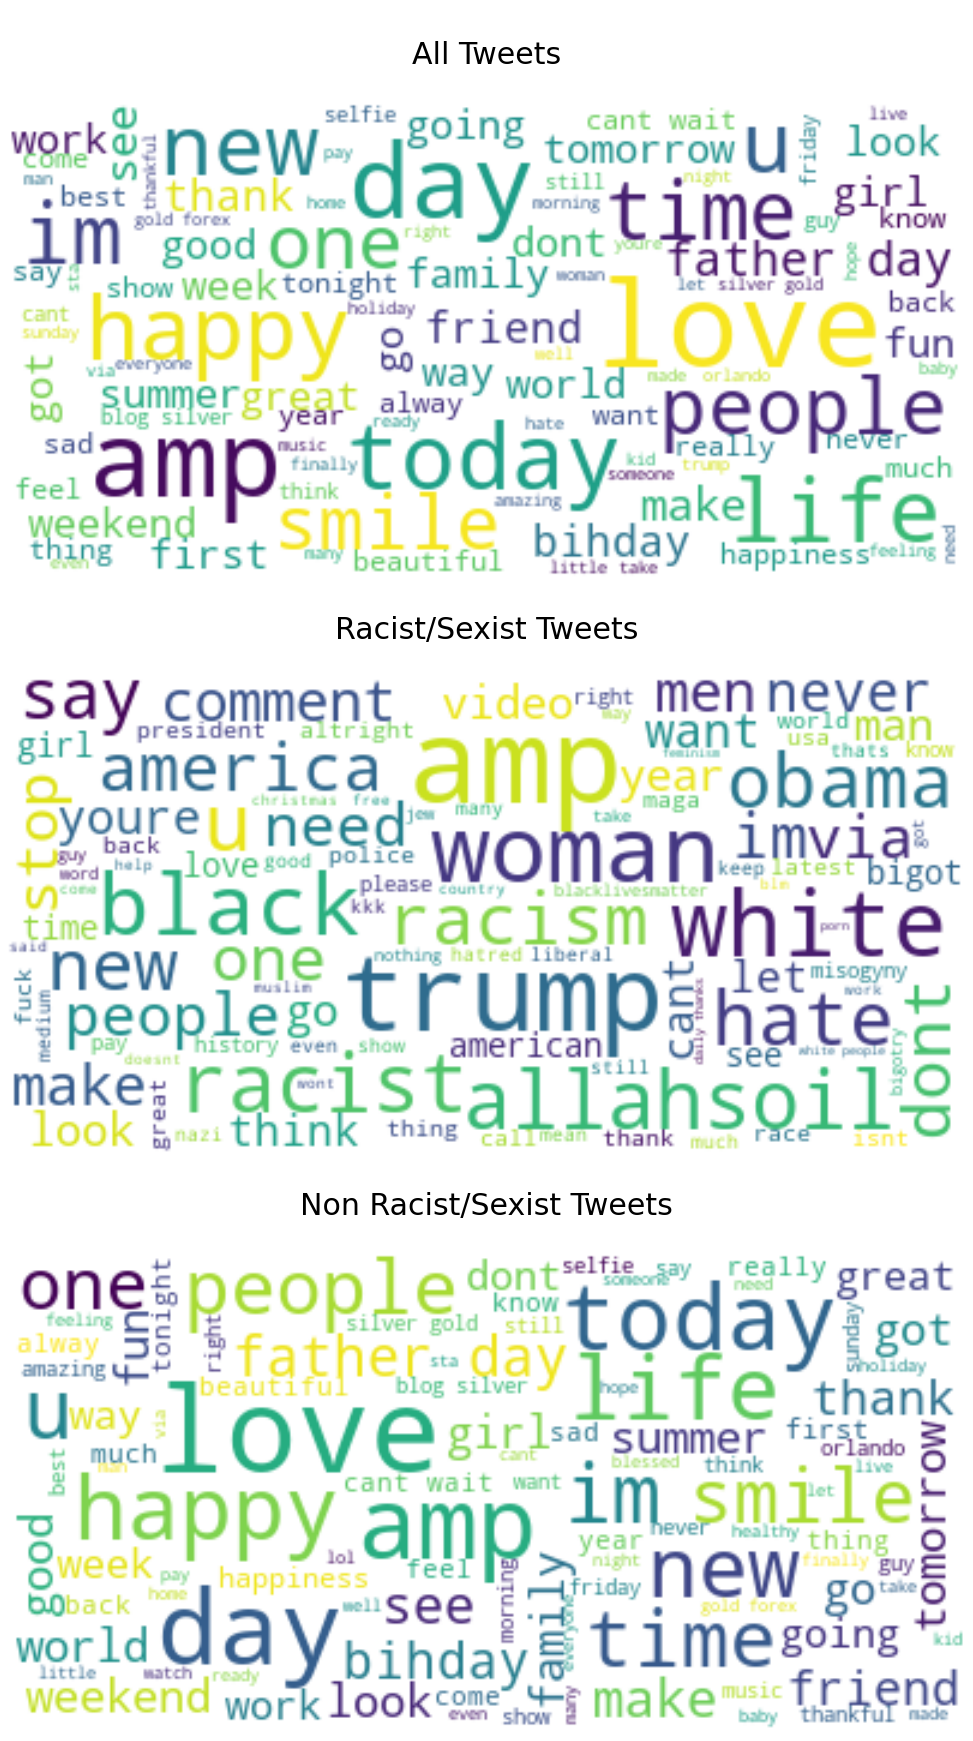

In [31]:
df_RS = df[df['label']==1]
df_NRS = df[df['label']==0]
tweet_All = " ".join(review for review in df.tweet)
tweet_RS = " ".join(review for review in df_RS.tweet)
tweet_NRS = " ".join(review for review in df_NRS.tweet)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_RS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_RS)
wordcloud_NRS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NRS)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('\nAll Tweets\n', fontsize=30)
ax[0].axis('off')
print('\n')
ax[1].imshow(wordcloud_RS, interpolation='bilinear')
ax[1].set_title('\nRacist/Sexist Tweets\n',fontsize=30)
ax[1].axis('off')
print('\n')
ax[2].imshow(wordcloud_NRS, interpolation='bilinear')
ax[2].set_title('\nNon Racist/Sexist Tweets\n',fontsize=30)
ax[2].axis('off')


In [32]:
# Looking at the dataset after various transformations
df.head(10)

,label,tweet,hashtags_count,num_count,char_count,stopwords_count,upper_case
0,0,father dysfunctional selfish drag kid dysfunct...,1,0,82,10,0
1,0,thanks lyft credit cant use cause dont offer w...,3,0,101,5,0
2,0,bihday majesty,0,0,17,1,0
3,0,model love u take u time ur,1,0,70,5,0
4,0,factsguide society motivation,1,0,32,1,0
5,0,huge fan fare big talking leave chaos pay disp...,1,0,96,6,0
6,0,camping tomorrow danny,0,0,63,0,0
7,0,next school year year exam cant think school e...,7,0,121,6,0
8,0,love land allin cavs champion cleveland clevel...,5,0,75,2,0
9,0,welcome im gr,1,0,36,3,0


In [33]:
# Separating data and labels

X = df.drop('label', axis = 'columns')
y = df['label']

## Model Evaluation Function

In [34]:
# defining a function to evaluate my models based on certain metrics 
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_test,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

## Creating pipeline for tokenizing and modelling

In [35]:
# CounterVectorization takes any text document and returns each unique word as a feature with the count of number of times that word occurs.
# 


vector = CountVectorizer(stop_words= "english",max_features=3000, ngram_range = (1,2))

trans = vector.fit(X['tweet'])
x = trans.transform(X['tweet'])
X = X.drop('tweet',axis = 'columns')
X = pd.concat([X.reset_index(drop = True),pd.DataFrame(x.todense()).reset_index(drop = True)],axis = 'columns')
X = X.fillna(0)

In [36]:
X

,hashtags_count,num_count,char_count,stopwords_count,upper_case,0,1,2,3,4,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1,0,82,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,101,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,70,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,32,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29525,0,1,49,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29526,0,0,63,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29527,2,0,107,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29528,0,0,49,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Dealing with imbalanced data

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over',over),('under', under)]
pipeline = PL(steps=steps)

X, y = pipeline.fit_resample(X, y)

In [38]:
# Standard stratified train test split being done here but other validation strategies can be explored

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20,stratify=y)

In [39]:
# Using simple untuned Random Forest Classifier Model

tfidf = TfidfTransformer()
model = RandomForestClassifier()

In [40]:
# Creating pipeline 

pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])
model_final = pipeline2.fit(X_train,y_train)
preds = model_final.predict(X_test)

## Evaluation

Train Result:
Accuracy Score: 99.28%
_______________________________________________
ROC-AUC score: 
 0.9942359472430485

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999198     0.980482  0.992845      0.989840      0.992959
recall         0.990062     0.998410  0.992845      0.994236      0.992845
f1-score       0.994609     0.989365  0.992845      0.991987      0.992861
support    17609.000000  8805.000000  0.992845  26414.000000  26414.000000
_______________________________________________
Confusion Matrix: 
 [[17434   175]
 [   14  8791]]


_______________________________________________

Test Result:
Accuracy Score: 94.91%
_______________________________________________
ROC-AUC score: 
 0.9365090486505886

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.9

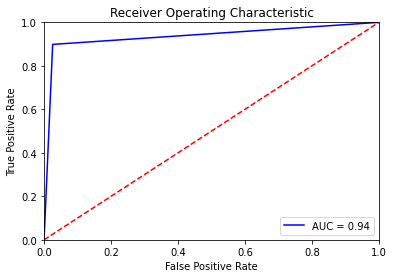

<AxesSubplot:>

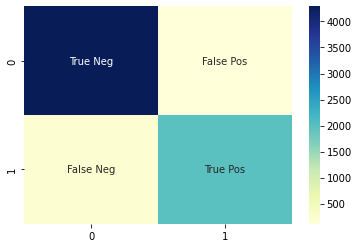

In [41]:
print_score(pipeline2, X_train, y_train, X_test, y_test, train=True)
print("\n_______________________________________________\n")
print_score(pipeline2, X_train, y_train, X_test, y_test, train=False)

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, pipeline2.predict(X_test)),annot = labels,fmt='',cmap = 'YlGnBu')

## ELI5

In [42]:
import eli5
eli5.show_weights(model, vec=vector, top= 100, feature_filter=lambda x: x != '<BIAS>' )

Weight,Feature
0.4469 ± 0.2148,absolute
0.0351 ± 0.0116,absolutely
0.0292 ± 0.0224,aap
0.0150 ± 0.0231,day fathersday
0.0113 ± 0.0180,love family
0.0096 ± 0.0091,altright
0.0080 ± 0.0127,happy happiness
0.0068 ± 0.0072,willing
0.0067 ± 0.0042,wood
0.0062 ± 0.0054,try


In [43]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#000CA4','#eb3446','Big Shoulders Inline Text','Smokum',50,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h4 class='font-effect-3d-float' style='font-family:"""+\
    font+"""; color:"""+fontcolor+"""; font-size:"""+\
    str(fontsize)+"""px;'>%s</h4>"""%string))
    
    
dhtml(' Do UPVOTE if you like my work ' )

## Credits

#### Remove Emojis: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
#### Formatting Code: https://www.kaggle.com/code/pranjalverma08/tps-08-cb-lgbm-xgb-starter
#### 